In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pysindy as ps
from scipy.integrate import solve_ivp
from scipy.ndimage import gaussian_filter1d
from scipy.integrate import cumtrapz

import os

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from pysindy.feature_library import FourierLibrary
from pysindy.feature_library import CustomLibrary
from pysindy.feature_library import PolynomialLibrary

# Import SINDy class
from pysindy import SINDy
from pysindy.optimizers import SR3
from pysindy.optimizers import ConstrainedSR3
from pysindy.optimizers import STLSQ

#import sdeint

# Integrator keywords for solve_ivp
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

In [5]:
def apply_gaussian_filter(data, sigma):
    return gaussian_filter1d(data, sigma=sigma)

def integrate_data(omega_data, dt=1, initial_theta=0):
    theta_data = cumtrapz(omega_data, dx=dt, initial=initial_theta)
    return theta_data

def calculate_sindy_models(omega_filtered, region_data_list, region_name, n=2):
    sindy_models = {}
    transformations = {
        "linear_time": lambda chunk: np.arange(0, len(chunk), 1).reshape(-1, 1),
        "exp_time": lambda chunk: (np.exp((chunk.index - chunk.index[0]).total_seconds().to_numpy() / 1000) - 1).reshape(-1, 1),
    }
    for transform_name, transform_func in transformations.items():
        sindy_models[transform_name] = []
        for chunk in region_data_list:
            if isinstance(chunk, str) or chunk.empty:
                continue
            theta_chunk = integrate_data(chunk['omega_filtered'].values)
            stacked_data_chunk = np.column_stack((theta_chunk, chunk['omega_filtered'].values))
            t_train_chunk = transform_func(chunk)
            x_train_augmented_chunk = np.hstack([stacked_data_chunk, t_train_chunk])
            feature_names = ["theta", "omega", transform_name]
            polynomial_library = PolynomialLibrary(degree=n)
            sparse_regression_optimizer = STLSQ(threshold=1e-10)
            model = SINDy(feature_names=feature_names,
                          feature_library=polynomial_library,
                          optimizer=sparse_regression_optimizer)
            model.fit(x_train_augmented_chunk, t=1)
            sindy_models[transform_name].append(model)
        print(f"Total transformations applied: {len(sindy_models)} for region {region_name}")
    return sindy_models

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def manual_integration(initial_state, t_span, dt, coefficients, transform_name, poly_degree=2, omega_threshold=0.5):
    th = np.zeros(t_span)  # Theta
    om = np.zeros(t_span)  # Omega
    t = np.zeros(t_span)   # Transformed time
    times = np.arange(0, t_span, 1)

    th[0] = initial_state[0]
    om[0] = initial_state[1]
    t[0] = initial_state[2]

    poly_library = PolynomialLibrary(degree=poly_degree)
    feature_names = ["theta", "omega", transform_name]
    poly_library.fit(np.zeros((1, 3)))

    for i in range(t_span - 1):
        state = np.array([th[i], om[i], t[i]]).reshape(1, -1)
        features = poly_library.transform(state)[0]
        derivatives = coefficients @ features
        th[i + 1] = th[i] + dt * derivatives[0]
        om[i + 1] = om[i] + dt * derivatives[1]
        
        if np.abs(om[i + 1]) > omega_threshold:
            convergence_value = om[i + 1]
            convergence_time = times[i + 1]
            print(f"Chunk diverged at step {i + 1}: omega = {convergence_value:.6f}, time = {convergence_time} seconds")
            return om[:i + 2], times[:i + 2], True  # Return with unstable flag
        
        if transform_name == "linear_time":
            t[i + 1] = t[i] + dt
        elif transform_name == "exp_time":
            t[i + 1] = np.exp((times[i + 1] * dt) / 1000) - 1

    return om, times, False  # Stable chunk

In [10]:
# Load and preprocess data
data = pd.read_pickle("C:/1. Power grid frequency data/df_South_Korea_cleansed_2024-08-15_2024-12-10.pkl")
data.index = pd.to_datetime(data.index)
data_filtered = data[(data['QI'] == 0) & (data['freq'].notna())].drop(columns=['QI']).dropna()
hourly_groups = data_filtered.groupby(data_filtered.index.floor('H'))
valid_hours = hourly_groups.filter(lambda x: len(x) == 3600)
valid_hours['omega'] = 2 * np.pi * (valid_hours['freq'] - 60)

# Apply Gaussian filter to omega
valid_hours['omega_filtered'] = apply_gaussian_filter(valid_hours['omega'], sigma=60)

# Split data into hourly chunks
region_data_list = [group for _, group in valid_hours.groupby(valid_hours.index.floor('H'))]
print(f"Total number of valid hourly chunks: {len(region_data_list)}")


# Calculate SINDy models
sindy_models = calculate_sindy_models(valid_hours['omega_filtered'], region_data_list, "South_Korea", n=2)

# Process all chunks for a chosen transformation
transform_name = "linear_time"
t_span = 3600
dt = 1

# Store results
all_omega_sim = []
all_rmse = []
unstable_count = 0  # Counter for unstable (diverged) chunks

for chunk_idx, (chunk, model) in enumerate(zip(region_data_list, sindy_models[transform_name])):
    #print(f"\nSINDy model for chunk {chunk_idx} ({transform_name}):")
    #model.print()

    coefficients = model.coefficients()
    initial_theta = integrate_data(chunk['omega_filtered'].values)[0]
    initial_omega = chunk['omega_filtered'].values[0]
    initial_time = 0
    initial_state = [initial_theta, initial_omega, initial_time]

    # Perform manual integration with omega threshold
    omega_sim, t_array, is_unstable = manual_integration(
        initial_state, t_span, dt, coefficients, transform_name, poly_degree=2, omega_threshold=0.5
    )

    if is_unstable:
        unstable_count += 1
        print(f"Chunk {chunk_idx} marked as unstable (diverged)")

    all_omega_sim.append(omega_sim)
    actual_omega = chunk['omega_filtered'].values[:len(omega_sim)]  # Match length
    rmse = calculate_rmse(actual_omega, omega_sim)
    all_rmse.append(rmse)
    print(f"Chunk {chunk_idx} RMSE: {rmse}")

# Summary statistics
total_chunks = len(region_data_list)
mean_rmse = np.mean(all_rmse)
std_rmse = np.std(all_rmse)
unstable_share = (unstable_count / total_chunks) * 100 if total_chunks > 0 else 0

print(f"\nSummary for {transform_name}:")
print(f"Mean RMSE across all chunks: {mean_rmse}")
print(f"Standard deviation of RMSE: {std_rmse}")
print(f"Number of unstable (diverged) chunks: {unstable_count} out of {total_chunks}")
print(f"Share of unstable (diverged) chunks: {unstable_share:.2f}%")


C:\Users\wp7528\AppData\Local\Temp\ipykernel_7880\436347729.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_groups = data_filtered.groupby(data_filtered.index.floor('H'))
C:\Users\wp7528\AppData\Local\Temp\ipykernel_7880\436347729.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  region_data_list = [group for _, group in valid_hours.groupby(valid_hours.index.floor('H'))]


Total number of valid hourly chunks: 2451
Total transformations applied: 1 for region South_Korea
Total transformations applied: 2 for region South_Korea
Chunk 0 RMSE: 0.1198058437760204
Chunk 1 RMSE: 0.07783829497667737
Chunk diverged at step 1815: omega = -0.500177, time = 1815 seconds
Chunk 2 marked as unstable (diverged)
Chunk 2 RMSE: 0.13717407905501267
Chunk 3 RMSE: 0.10084167969077934
Chunk 4 RMSE: 0.051521137706633954
Chunk 5 RMSE: 0.11197258662289102
Chunk 6 RMSE: 0.03617301467208785
Chunk 7 RMSE: 0.043100392314108754
Chunk diverged at step 652: omega = 0.501877, time = 652 seconds
Chunk 8 marked as unstable (diverged)
Chunk 8 RMSE: 0.11390235840378471
Chunk 9 RMSE: 0.05683777129323938
Chunk diverged at step 1948: omega = -0.504908, time = 1948 seconds
Chunk 10 marked as unstable (diverged)
Chunk 10 RMSE: 0.12082527975621714
Chunk diverged at step 2787: omega = -0.500316, time = 2787 seconds
Chunk 11 marked as unstable (diverged)
Chunk 11 RMSE: 0.08867995429248138
Chunk diverg

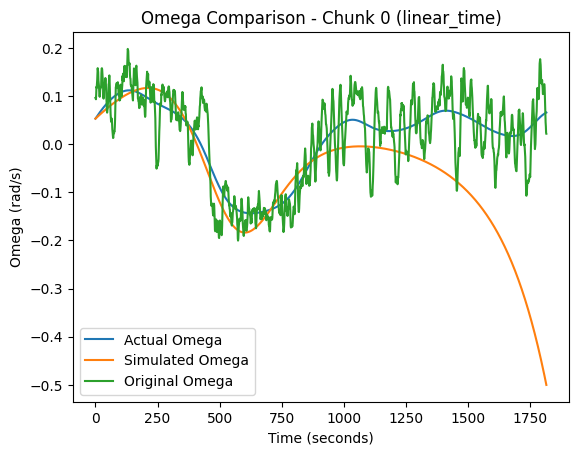

In [11]:
# Ensure all arrays have the same length
min_length = min(len(t_array), len(region_data_list[2]['omega_filtered'].values), len(all_omega_sim[2]))

# Plot results for the first chunk also original unfiltered omega
plt.plot(t_array[:min_length], region_data_list[2]['omega_filtered'].values[:min_length], label="Actual Omega")
plt.plot(t_array[:min_length], all_omega_sim[2][:min_length], label="Simulated Omega")
plt.plot(t_array[:min_length], region_data_list[2]['omega'].values[:min_length], label="Original Omega")
plt.xlabel("Time (seconds)")
plt.ylabel("Omega (rad/s)")
plt.legend()
plt.title(f"Omega Comparison - Chunk 0 ({transform_name})")
plt.show()

In [ ]:
import pickle
import numpy as np

output_dir = "C:/1. Power grid frequency data/results/"
transformations = ["linear_time", "exp_time"]

for transform_name in transformations:
    omega_sim_file = f"{output_dir}all_omega_sim_{transform_name}_n2_no_constraints.pkl"
    rmse_file = f"{output_dir}all_rmse_{transform_name}_n2_no_constraints.pkl"

    # Load all_omega_sim
    with open(omega_sim_file, 'rb') as f:
        all_omega_sim = pickle.load(f)
    print(f"Loaded all_omega_sim for {transform_name} with {len(all_omega_sim)} chunks")

    # Load all_rmse
    with open(rmse_file, 'rb') as f:
        all_rmse = pickle.load(f)
    print(f"Loaded all_rmse for {transform_name} with {len(all_rmse)} values")

    # Summary statistics
    mean_rmse = np.mean(all_rmse)
    std_rmse = np.std(all_rmse)
    print(f"{transform_name} - Mean RMSE: {mean_rmse}, Std RMSE: {std_rmse}")

In [ ]:
plt.plot(t_array, region_data_list[0]['omega_filtered'].values[:t_span], label="Actual Omega")
plt.plot(t_array, all_omega_sim[0], label="Simulated Omega")
plt.xlabel("Time (seconds)")
plt.ylabel("Omega (rad/s)")
plt.legend()
plt.title(f"Omega Comparison - Chunk 0 ({transform_name})")
plt.show()

   sigma                                      rmse_filtered  \
0     15  [0.11675965709150288, 0.12049312391705191, 0.0...   
1     30  [0.13225614962750187, 0.09169484210936286, 0.0...   
2     45  [0.1298435759499267, 0.09782625864991973, 0.04...   
3     60  [0.11954142671069488, 0.09659272993089382, 0.0...   
4     75  [0.11035866662756907, 0.07410171804924641, 0.0...   

                                       rmse_original  
0  [0.12677959152989648, 0.1311810031691463, 0.05...  
1  [0.14587754652466123, 0.11438854451310639, 0.0...  
2  [0.14657337616229615, 0.12226678014335929, 0.0...  
3  [0.1400714495866812, 0.12227298373056529, 0.06...  
4  [0.1346455351012844, 0.10721723207412755, 0.09...  
   sigma rmse_filtered rmse_original
0     15       0.11676       0.11676
0     15      0.120493      0.120493
0     15      0.045575      0.045575
0     15      0.013495      0.013495
0     15      0.069892      0.069892


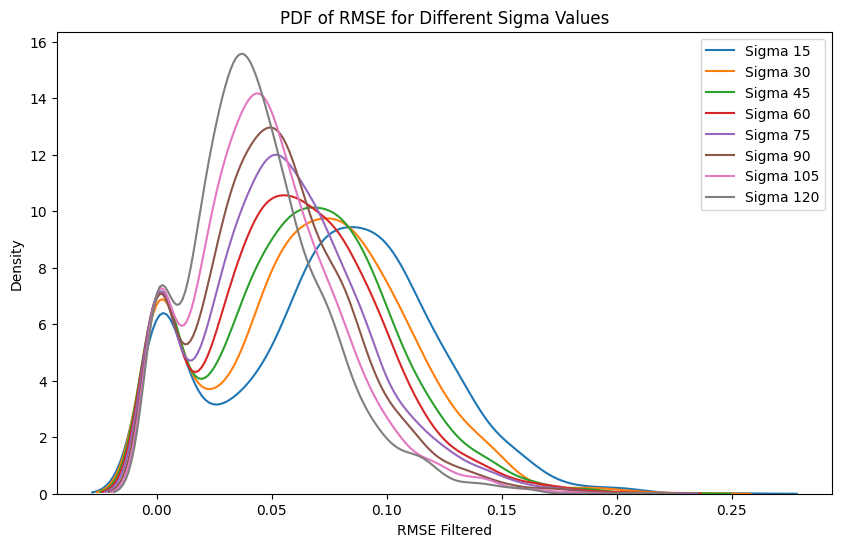

In [3]:
import seaborn as sns

#Save the results to a DataFrame
rmse_df = pd.DataFrame(rmse_values)
#rmse_df.to_csv("rmse_values_linear_n2.csv", index=False)

# Load the saved MSE values
#rmse_df = pd.read_csv("mse_values.csv")

print(rmse_df.head())

# Expand the 'rmse_filtered' column into separate columns
rmse_df_exploded = rmse_df.explode('rmse_filtered')
# Expand the 'rmse_original' column into separate columns
rmse_df_exploded['rmse_original'] = rmse_df_exploded['rmse_filtered']
rmse_df_exploded = rmse_df_exploded.explode('rmse_original')

print(rmse_df_exploded.head())
rmse_df_exploded = rmse_df_exploded.reset_index(drop=True)

# Plot the PDF of RMSE values for each sigma using KDE
plt.figure(figsize=(10, 6))
for sigma in rmse_df['sigma'].unique():
    subset = rmse_df_exploded[rmse_df_exploded['sigma'] == sigma]
    #sns.histplot(subset['rmse_filtered'], label=f"Sigma {sigma}", kde=True)
    sns.kdeplot(subset['rmse_filtered'], label=f"Sigma {sigma}")

plt.xlabel("RMSE Filtered")
plt.ylabel("Density")
plt.title("PDF of RMSE for Different Sigma Values")
plt.legend()
plt.show()

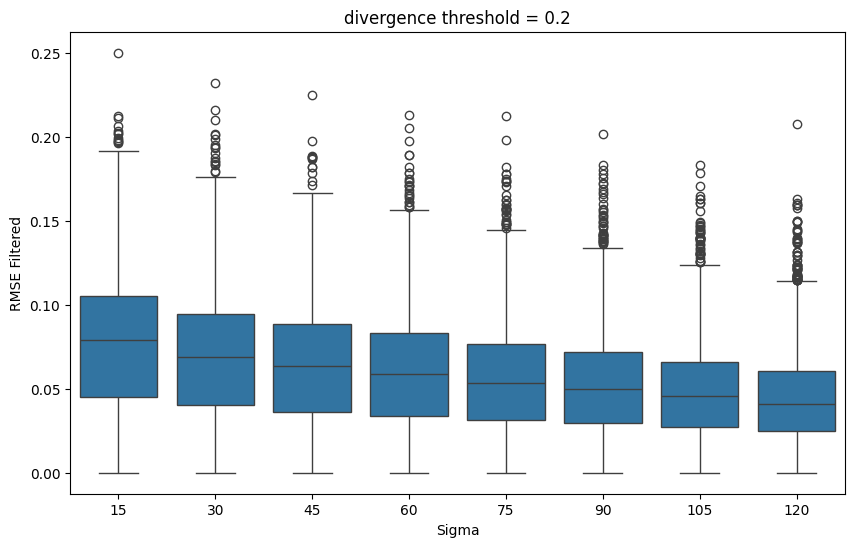

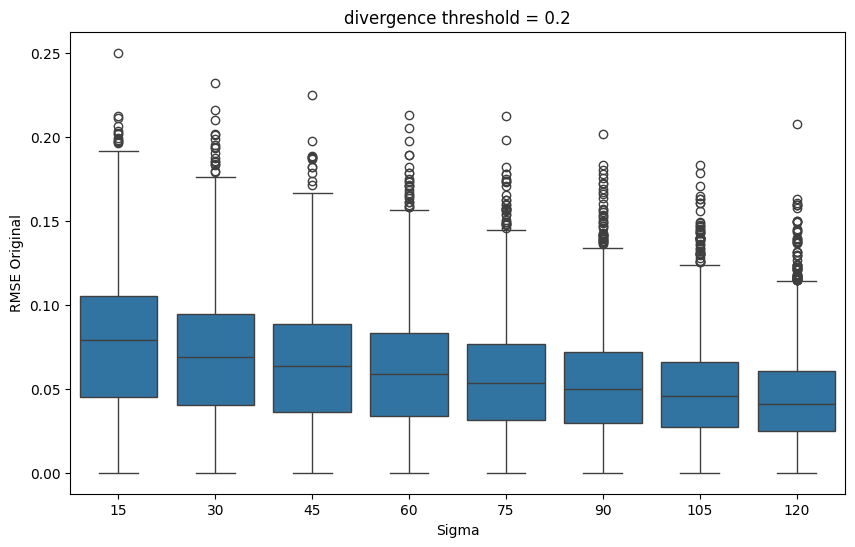

In [4]:
# plot the boxplot of RMSE rmse_filtered values for each sigma
plt.figure(figsize=(10, 6))
sns.boxplot(x='sigma', y='rmse_filtered', data=rmse_df_exploded)
plt.xlabel("Sigma")
plt.ylabel("RMSE Filtered")
plt.title("divergence threshold = 0.2")
plt.show()

#plot the boxplot of RMSE rmse_original values for each sigma
plt.figure(figsize=(10, 6))
sns.boxplot(x='sigma', y='rmse_original', data=rmse_df_exploded)
plt.xlabel("Sigma")
plt.ylabel("RMSE Original")
plt.title("divergence threshold = 0.2")
plt.show()

In [5]:
# Calculate the mean and standard deviation of RMSE values for each sigma
mean_rmse_values = rmse_df_exploded.groupby('sigma')['rmse_filtered'].apply(np.mean)
std_rmse_values = rmse_df_exploded.groupby('sigma')['rmse_filtered'].apply(np.std)
print(mean_rmse_values)
print(std_rmse_values)
# find out the maximum value of the rmse values for sigma 60
max_rmse = rmse_df_exploded[rmse_df_exploded['sigma'] == 60]['rmse_filtered'].max()
print(max_rmse)

# find out the length of the rmse values for rmse greater than 40
len_rmse_10 = rmse_df_exploded[rmse_df_exploded['rmse_filtered'] > 50].groupby('sigma')['rmse_filtered'].apply(len)
len_rmse_10


sigma
15     0.074694
30     0.067014
45     0.062524
60     0.059019
75     0.055306
90     0.051875
105    0.048057
120    0.044397
Name: rmse_filtered, dtype: float64
sigma
15     0.044522
30     0.041329
45     0.039064
60     0.037362
75     0.035342
90     0.033102
105    0.030963
120    0.029204
Name: rmse_filtered, dtype: float64
0.21297060832802214


Series([], Name: rmse_filtered, dtype: object)

In [6]:
# find out the length of the rmse values for each sigma
len_rmse = rmse_df_exploded.groupby('sigma')['rmse_filtered'].apply(len)
print(len_rmse)


#rmse_df_exploded = rmse_df_exploded.reset_index(drop=True)
#print(rmse_df_exploded.head())

# Create a new column to keep track of cumulative index for each sigma
sigma_group_sizes = rmse_df_exploded.groupby('sigma').size().cumsum()

# Group by sigma and find the minimum MSE and corresponding index for both 'mse_filtered' and 'mse_original'
min_rmse_per_sigma_filtered = rmse_df_exploded.groupby('sigma')['rmse_filtered'].idxmin()
min_rmse_per_sigma_original = rmse_df_exploded.groupby('sigma')['rmse_original'].idxmin()

# Initialize lists to store the results for both filtered and original MSE
relative_indices_filtered = []
global_indices_filtered = []
relative_indices_original = []
global_indices_original = []

# Calculate the relative index and global index for each sigma block (for both mse_filtered and mse_original)
for sigma in min_rmse_per_sigma_filtered.index:
    # Find the starting index of the sigma block
    block_start_idx = 0 if sigma == 15 else sigma_group_sizes.loc[sigma - 15]
    
    # Get the index for mse_filtered and mse_original
    idx_filtered = min_rmse_per_sigma_filtered[sigma]
    idx_original = min_rmse_per_sigma_original[sigma]
    
    # Calculate the relative and global indices for mse_filtered
    relative_index_filtered = idx_filtered - block_start_idx
    global_index_filtered = idx_filtered
    
    # Calculate the relative and global indices for mse_original
    relative_index_original = idx_original - block_start_idx
    global_index_original = idx_original
    
    # Append the values to the lists
    relative_indices_filtered.append(relative_index_filtered)
    global_indices_filtered.append(global_index_filtered)
    relative_indices_original.append(relative_index_original)
    global_indices_original.append(global_index_original)

# Ensure all lists are of the same length
min_rmse_per_sigma_filtered = min_rmse_per_sigma_filtered[:len(relative_indices_filtered)]
min_rmse_per_sigma_original = min_rmse_per_sigma_original[:len(relative_indices_original)]

# Create a DataFrame to store the results for both filtered and original MSE
min_rmse_results = pd.DataFrame({
    'Sigma': min_rmse_per_sigma_filtered.index,
    'Minimum MSE (Filtered)': rmse_df_exploded.loc[min_rmse_per_sigma_filtered, 'rmse_filtered'].values,
    'Relative Index (Filtered)': relative_indices_filtered,
    #'Global Index (Filtered)': global_indices_filtered,
    'Minimum MSE (Original)': rmse_df_exploded.loc[min_rmse_per_sigma_original, 'rmse_original'].values,
    'Relative Index (Original)': relative_indices_original,
    #'Global Index (Original)': global_indices_original
})

# Print the results as a clean table
print(min_rmse_results)

sigma
15     2451
30     2451
45     2451
60     2451
75     2451
90     2451
105    2451
120    2451
Name: rmse_filtered, dtype: int64
   Sigma Minimum MSE (Filtered)  Relative Index (Filtered)  \
0     15                    0.0                       2179   
1     30               0.000001                       2387   
2     45               0.000002                        903   
3     60               0.000001                       1694   
4     75                    0.0                        903   
5     90                    0.0                       2130   
6    105               0.000004                       1755   
7    120               0.000001                       1860   

  Minimum MSE (Original)  Relative Index (Original)  
0                    0.0                       2179  
1               0.000001                       2387  
2               0.000002                        903  
3               0.000001                       1694  
4                    0.0           

C:\Users\wp7528\AppData\Local\Temp\ipykernel_15792\1803767233.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hour = valid_hours.index.floor('H').unique()[min_mse_index]
C:\Users\wp7528\AppData\Local\Temp\ipykernel_15792\1803767233.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hour_data = valid_hours.loc[valid_hours.index.floor('H') == hour]


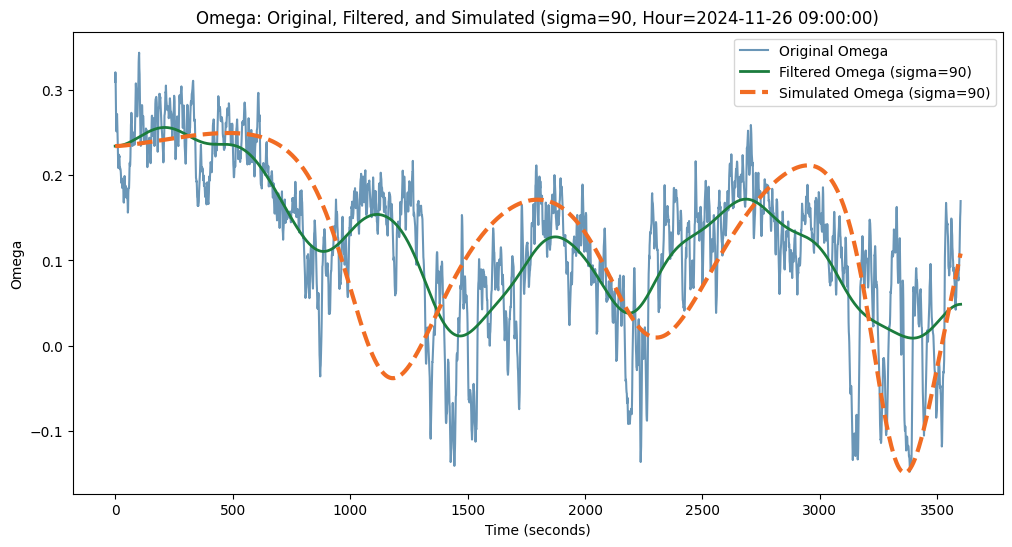

In [10]:
# Given values: sigma = 15, index = 1296
sigma_value = 90
min_mse_index = 2179

# Retrieve the corresponding hour for the minimum MSE index
hour = valid_hours.index.floor('H').unique()[min_mse_index]

# Get the data for the chosen hour
hour_data = valid_hours.loc[valid_hours.index.floor('H') == hour]

# Apply Gaussian filter to omega for the chosen hour and sigma
omega_filtered_hour = apply_gaussian_filter(hour_data['omega'].values, sigma_value)

# Retrieve the SINDy model corresponding to the minimum MSE index (sigma=15, index=1296)
sindy_model_for_hour = all_sindy_models[min_mse_index]  # Use the accumulated models list

# Simulate omega using the SINDy model for this hour
omega_simulated = np.zeros(default_simulation_steps)
th_simulated = np.zeros(default_simulation_steps)
t_simulated = np.arange(default_simulation_steps) * delta_t

# Initialize initial conditions
th_simulated[0] = integrate_data(omega_filtered_hour)[0]  # First value of theta
omega_simulated[0] = omega_filtered_hour[0]  # First omega

# Extract coefficients from the SINDy model
coefficients = sindy_model_for_hour.coefficients()

# Run the simulation
for i in range(default_simulation_steps - 1):
    th_simulated[i + 1] = th_simulated[i] + delta_t * (
        coefficients[0, 0] + coefficients[0, 1] * th_simulated[i] + coefficients[0, 2] * omega_simulated[i] +
        coefficients[0, 3] * t_simulated[i] + coefficients[0, 4] * th_simulated[i]**2 + 
        coefficients[0, 5] * th_simulated[i] * omega_simulated[i] + coefficients[0, 6] * th_simulated[i] * t_simulated[i] +
        coefficients[0, 7] * omega_simulated[i]**2 + coefficients[0, 8] * omega_simulated[i] * t_simulated[i] +
        coefficients[0, 9] * t_simulated[i]**2
    )

    omega_simulated[i + 1] = omega_simulated[i] + delta_t * (
        coefficients[1, 0] + coefficients[1, 1] * th_simulated[i] + coefficients[1, 2] * omega_simulated[i] +
        coefficients[1, 3] * t_simulated[i] + coefficients[1, 4] * th_simulated[i]**2 + 
        coefficients[1, 5] * th_simulated[i] * omega_simulated[i] + coefficients[1, 6] * th_simulated[i] * t_simulated[i] +
        coefficients[1, 7] * omega_simulated[i]**2 + coefficients[1, 8] * omega_simulated[i] * t_simulated[i] +
        coefficients[1, 9] * t_simulated[i]**2
    )

    # Clip the values to avoid overflow
    th_simulated[i + 1] = np.clip(th_simulated[i + 1], -1e10, 1e10)
    omega_simulated[i + 1] = np.clip(omega_simulated[i + 1], -1e10, 1e10)

# Plot the original, filtered, and simulated data
plt.figure(figsize=(12, 6))

# Original omega data
plt.plot(hour_data['omega'].values, label='Original Omega', alpha=0.7, color='#2b6a99')

# Filtered omega data
plt.plot(omega_filtered_hour, label=f'Filtered Omega (sigma={sigma_value})', linestyle='-', linewidth=2, color='#1b7c3d')

# Simulated omega data
plt.plot(omega_simulated, label=f'Simulated Omega (sigma={sigma_value})',linestyle='--', linewidth=3, color='#f16c23')

# Labels and title
plt.xlabel('Time (seconds)')
plt.ylabel('Omega')
plt.title(f"Omega: Original, Filtered, and Simulated (sigma={sigma_value}, Hour={hour})")
plt.legend()

In [33]:
sindy_models_n2 = calculate_sindy_models(omega_filtered, 'Balearic', n=2)
# Function to calculate RMSE
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Define simulation parameters
s = 10
delta_t = 1 / s
default_simulation_steps = 3600*s 
divergence_limit = 3600*s  # Limit for diverging rows
error_simulation_limit = 3600*s  # Limit for rows with numerical errors
divergence_threshold = 100  # Threshold to detect divergence

rmse_values_n2 = []  # Store RMSE values for each row
om_n2 = []
unstable_n2 = 0
# Suppress RuntimeWarning to be caught as an exception
np.seterr(over='raise', divide='raise', invalid='raise')


for idx in range(len(sindy_models_n2)):
    th = np.zeros(default_simulation_steps)
    om = np.zeros(default_simulation_steps)
    t = np.arange(0,default_simulation_steps//s,delta_t) 

    # Set initial conditions
    th[0], om[0] = integrate_data(omega_filtered[idx])[0], omega_filtered[idx][0]

    # Extract coefficients from the SINDy model
    coefficients = sindy_models_n2[idx].coefficients()

    limited_simulation = False  # Flag to indicate whether to limit the simulation

    try:
        for i in range(default_simulation_steps - 1):
            th[i + 1] = th[i] + delta_t * (coefficients[0, 0] + coefficients[0, 1] * th[i] + coefficients[0, 2] * om[i] + coefficients[0, 3] * t[i] +
                                       coefficients[0, 4] * th[i]**2 + coefficients[0, 5] * th[i] * om[i] + coefficients[0, 6] * th[i] * t[i] +
                                       coefficients[0, 7] * om[i]**2 + coefficients[0, 8] * om[i] * t[i] + coefficients[0, 9] * t[i]**2)
            om[i + 1] = om[i] + delta_t * (coefficients[1, 0] + coefficients[1, 1] * th[i] + coefficients[1, 2] * om[i] + coefficients[1, 3] * t[i] +
                                       coefficients[1, 4] * th[i]**2 + coefficients[1, 5] * th[i] * om[i] + coefficients[1, 6] * th[i] * t[i] +
                                       coefficients[1, 7] * om[i]**2 + coefficients[1, 8] * om[i] * t[i] + coefficients[1, 9] * t[i]**2) 
            
            # Check for divergence and limit simulation if detected
            if (np.abs(om[i + 1]) > divergence_threshold) and not limited_simulation:
                limited_simulation = True
                unstable_n2 += 1
                simulation_end = min(i + 2, 3600*s)  # Ensure we don't exceed the bounds
                print(f"Row {idx} limited to first {simulation_end} points due to divergence.")
                break  # Exit the current for-loop

    except (FloatingPointError, OverflowError, RuntimeWarning) as e:
        print(f'Row {idx} encountered an error: {e}. Limiting to first {error_simulation_limit} data points.')
        limited_simulation = True
        simulation_end = 3600*s

    if limited_simulation:
        # If simulation is limited, use only the relevant portion of om
        om_used_for_rmse = om[:simulation_end]
    else:
        # Otherwise, use the full simulation data
        om_used_for_rmse = om

    om_n2.append(om_used_for_rmse)  # Store the om array (either full or limited)
    if limited_simulation == False:       
        # Calculate RMSE using the appropriate portion of omega_filtered
        omega_filtered_segment = omega_filtered[idx][:len(om_used_for_rmse)//s]
        rmse = calculate_rmse(omega_filtered_segment, om_used_for_rmse[::s])
        rmse_values_n2.append(rmse)

# After the loop
print("RMSE values:", rmse_values_n2)
share_of_unstable_intervals_n2 = unstable_n2 / len(sindy_models_n2)
print("Share of unstable intervals:", share_of_unstable_intervals_n2)


Total number of SINDy models generated: 2106
Row 5 limited to first 6385 points due to divergence.
Row 8 limited to first 9382 points due to divergence.
Row 13 limited to first 24214 points due to divergence.
Row 20 limited to first 12079 points due to divergence.
Row 30 limited to first 32137 points due to divergence.
Row 39 limited to first 35377 points due to divergence.
Row 41 limited to first 34007 points due to divergence.
Row 48 limited to first 30329 points due to divergence.
Row 51 limited to first 18875 points due to divergence.
Row 52 limited to first 14749 points due to divergence.
Row 54 limited to first 34454 points due to divergence.
Row 56 limited to first 28809 points due to divergence.
Row 63 limited to first 31882 points due to divergence.
Row 65 limited to first 34220 points due to divergence.
Row 67 limited to first 12125 points due to divergence.
Row 69 limited to first 12389 points due to divergence.
Row 70 limited to first 4335 points due to divergence.
Row 71 l